In [1]:

# !pip install torch torchvision torchaudio
# !pip install rockpool
# !pip install --upgrade jax jaxlib
# !pip install samna
# !pip install bitstruct
# !pip install librosa
# !pip install matplotlib
# !pip install numpy
# !pip install scipy
# !pip install pandas
# !pip install tqdm

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from tqdm import tqdm
from IPython.display import Audio, display

# --- Torch Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# --- Rockpool & Neuromorphic Imports ---
from rockpool.devices.xylo.syns61201 import AFESim
from rockpool.timeseries import TSContinuous
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

# --- Hardware Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Visualizing: microwave / take77.wav


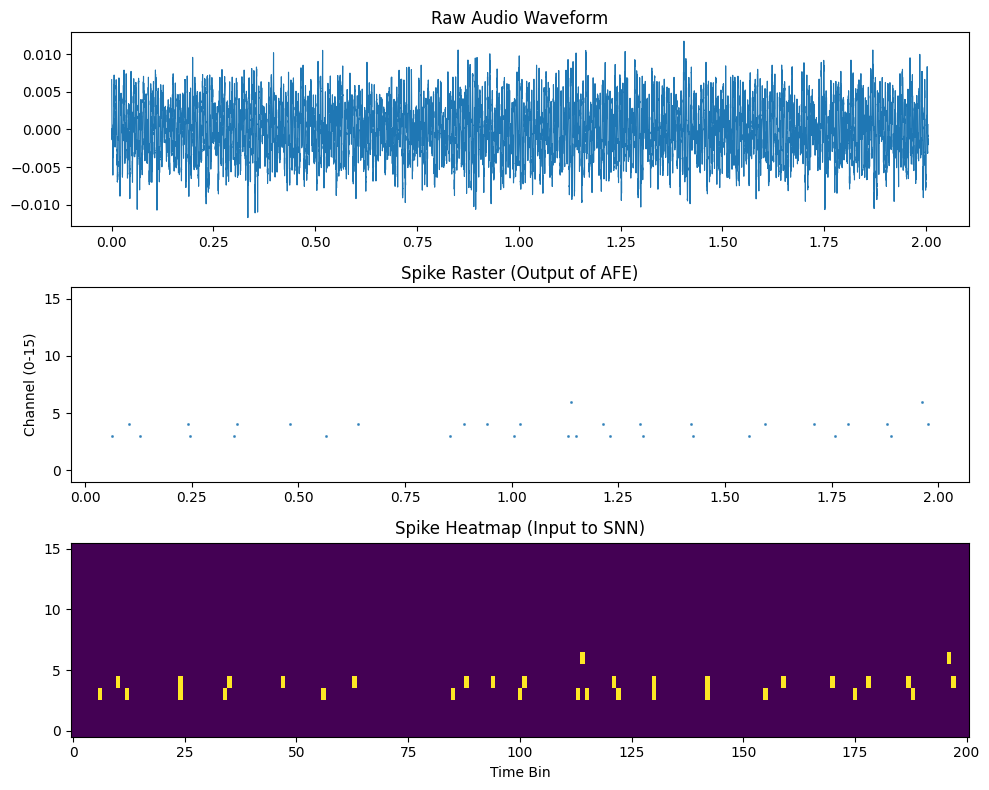

In [2]:

# Path to raw audio files (for visualization)
TRAIN_SEGMENTS_PATH = '/Users/deven/Neuromorphic Project/Dataset/building_106_kitchen/training_segments'
# Path to pre-processed spike dataset (for training)
DATASET_PATH = '/Users/deven/Neuromorphic Project/SoundClassificationProject/SoundClassification/kitchen_spike_dataset/sample_info.npy'

# AFE Parameters
fs = 110e3                          # Input sampling frequency (Hz)
raster_period = 10e-3               # Output time-step (10ms)
max_spike_per_raster_period = 15    # Max events per step

afe = AFESim(
        fs=fs,
        raster_period=raster_period,
        max_spike_per_raster_period=max_spike_per_raster_period,
        add_noise=False,            # Set True for high-noise simulation
        add_offset=False,
        add_mismatch=False,
        seed=None,
).timed()

def wav_to_spikes(path, afe_module):
    audio, sr = librosa.load(path, sr=None, mono=True)
    times = np.arange(len(audio)) / sr
    ts_audio = TSContinuous(times, audio[:, None])
    
    # Pass through Analog Front-End Simulation
    spikes, state, rec = afe_module(ts_audio)
    return spikes, audio, sr


try:
    # Get a random class and file
    class_directories = [d for d in os.listdir(TRAIN_SEGMENTS_PATH) if os.path.isdir(os.path.join(TRAIN_SEGMENTS_PATH, d))]
    if class_directories:
        random_class = random.choice(class_directories)
        class_path = os.path.join(TRAIN_SEGMENTS_PATH, random_class)
        wav_files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
        
        if wav_files:
            random_file = random.choice(wav_files)
            full_path = os.path.join(class_path, random_file)
            print(f"Visualizing: {random_class} / {random_file}")

            # Convert to Spikes
            spike_out, audio_wave, sr = wav_to_spikes(full_path, afe)
            
            # Plot
            fig, ax = plt.subplots(3, 1, figsize=(10, 8), gridspec_kw={'height_ratios':[1,1,1]})
            
            # 1. Waveform
            ax[0].plot(np.arange(len(audio_wave))/sr, audio_wave, lw=0.8)
            ax[0].set_title("Raw Audio Waveform")
            
            # 2. Spike Scatter
            ax[1].scatter(spike_out.times, spike_out.channels, s=5, marker='.', alpha=0.7)
            ax[1].set_title("Spike Raster (Output of AFE)")
            ax[1].set_ylabel("Channel (0-15)")
            ax[1].set_ylim(-1, 16)
            
            # 3. Heatmap
            raster_matrix = spike_out.raster(dt=raster_period, add_events=True)
            ax[2].imshow(raster_matrix.T, aspect="auto", origin="lower", cmap='viridis')
            ax[2].set_title("Spike Heatmap (Input to SNN)")
            ax[2].set_xlabel("Time Bin")
            
            plt.tight_layout()
            plt.show()
            
            # Play Audio
            # display(Audio(full_path)) 
except Exception as e:
    print(f"Skipping visualization (Check paths): {e}")

In [3]:

class SpikeRasterDataset(Dataset):
    def __init__(self, sample_info_path, transform=None):
        # Load the metadata containing the list of files and labels
        self.sample_info = np.load(sample_info_path, allow_pickle=True)
        self.transform = transform
        

        # This is the path currently written inside sample_info.npy file
        self.old_root = '/content/drive/MyDrive/D7046E_SNN_project_dataset/kitchen_spike_dataset'
        
        self.new_root = '/Users/deven/Neuromorphic Project/SoundClassificationProject/SoundClassification/kitchen_spike_dataset'

    def __len__(self):
        return len(self.sample_info)

    def __getitem__(self, idx):
        # 3. Get the old path from the file
        old_path, class_idx = self.sample_info[idx]
        
        # We replace the start of the string (old_root) with the new location (new_root)
        current_path = str(old_path).replace(self.old_root, self.new_root)

        # Load the file using the corrected path
        try:
            spikes = np.load(current_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"Could not find file at: {current_path}")

        if self.transform is not None:
            spikes = self.transform(spikes)
            
        # Convert to Float Tensor
        spikes = torch.from_numpy(spikes).float()
        return spikes, class_idx

# Load Dataset
if os.path.exists(DATASET_PATH):
    dataset = SpikeRasterDataset(DATASET_PATH)
    
    # Split
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
    
    # Dataloaders
    BATCH_SIZE = 64
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Dataset Loaded. Train: {train_size}, Val: {val_size}, Test: {test_size}")
else:
    print(f"Dataset not found at {DATASET_PATH}")

Dataset Loaded. Train: 1031, Val: 220, Test: 222


In [4]:
# temporal SNN 
INPUT_CHANNELS = 16       
HIDDEN_NEURONS = 512      # High capacity
OUTPUT_CLASSES = 24       
DT = 1e-2                 # 10ms

class ImprovedTemporalRSNN(nn.Module):
    def __init__(self, in_ch, hidden_ch, out_ch, dt):
        super().__init__()
        
        self.encoder = LinearTorch((in_ch, hidden_ch), has_bias=False)
        
        self.recurrent = Residual(
            LinearTorch((hidden_ch, hidden_ch), has_bias=False)
        )
        
        # Batch Norm for stability
        self.batch_norm = nn.BatchNorm1d(hidden_ch)
        
        # Long memory (200ms)
        self.lif_hidden = LIFTorch(
            shape=(hidden_ch,), 
            tau_mem=torch.tensor([100e-3]), 
            tau_syn=torch.tensor([100e-3]), 
            bias=torch.tensor(0.0),
            dt=dt
        )
        
        self.decoder = LinearTorch((hidden_ch, out_ch), has_bias=False)
        
        self.lif_out = LIFTorch(
            shape=(out_ch,), 
            tau_mem=torch.tensor([100e-3]),
            tau_syn=torch.tensor([100e-3]),
            dt=dt
        )

    def forward(self, x):
        # x: [Batch, Time, Channels]
        enc_out, _, _ = self.encoder(x)
        rec_out, _, _ = self.recurrent(enc_out)
        
        # Apply BatchNorm
        bn_in = rec_out.permute(0, 2, 1)
        bn_out = self.batch_norm(bn_in)
        bn_out = bn_out.permute(0, 2, 1)
        
        spikes_hidden, _, _ = self.lif_hidden(bn_out)
        dec_out, _, _ = self.decoder(spikes_hidden)
        spikes_out, _, _ = self.lif_out(dec_out)
        
        return spikes_out, None, None # Return tuple to match loop structure

net = ImprovedTemporalRSNN(INPUT_CHANNELS, HIDDEN_NEURONS, OUTPUT_CLASSES, DT)
net.to(device)

ImprovedTemporalRSNN(
  (encoder): LinearTorch  with shape (16, 512)
  (recurrent): TorchResidual  with shape (512, 512) {
      LinearTorch '0_LinearTorch' with shape (512, 512)
  }
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lif_hidden): LIFTorch  with shape (512, 512)
  (decoder): LinearTorch  with shape (512, 24)
  (lif_out): LIFTorch  with shape (24, 24)
)

In [5]:
# training loop
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epochs = 50

accuracy = []
loss_t = []

with tqdm(range(num_epochs), unit='Epoch', desc='Training') as pbar:
    for _ in pbar:
        correct = 0
        total = 0
        running_loss = 0
        
        net.train()

        for events, labels in train_loader:
            events = events.to(device)
            
            # Label conversion logic
            arr = np.array(labels, dtype=np.long)
            labels = torch.tensor(arr, dtype=torch.long).to(device)
            
            optimizer.zero_grad()

            # Forward pass
            output, _, _ = net(events)

            # Note: output shape is [Batch, Time, Classes]
            summed_output = torch.sum(output, dim=1) 

            loss = loss_fun(summed_output, labels)

            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            
            optimizer.step()

            # Calculate metrics
            predicted = torch.argmax(summed_output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        # track of the accuracy for this epoch
        this_accuracy = (correct / total) * 100
        this_loss = running_loss / len(train_loader) # Average loss per batch
        
        accuracy.append(this_accuracy)
        loss_t.append(this_loss)
        
        pbar.set_postfix(Loss=f'{this_loss:.2f}', Accuracy=f'{this_accuracy:.1f}%')

print(f"Final Training Accuracy: {accuracy[-1]:.3f}%")

Training: 100%|██████████| 50/50 [1:07:20<00:00, 80.80s/Epoch, Accuracy=39.0%, Loss=2.20]  

Final Training Accuracy: 38.991%


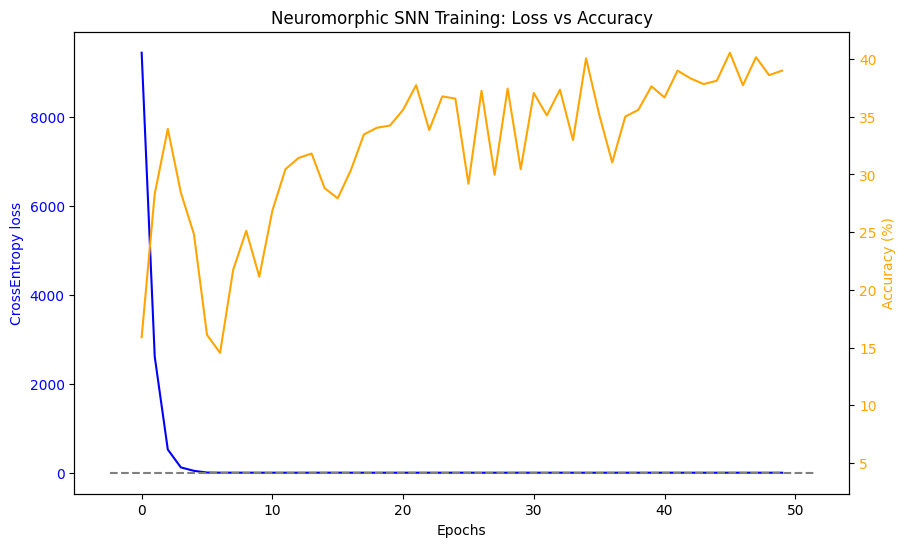

In [6]:

# - Plot the Training Loss
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(loss_t, color='blue', label='Loss')
ax.set_ylabel('CrossEntropy loss', color='blue')
# ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.tick_params(axis='y', labelcolor='blue')

ax2 = ax.twinx()
ax2.plot(accuracy, color='orange', label='Accuracy')
ax2.plot(ax2.get_xlim(), [100/OUTPUT_CLASSES, 100/OUTPUT_CLASSES], '--', color='gray', label='Chance Level')
ax2.set_ylabel('Accuracy (%)', color='orange')
ax2.set_yscale('linear')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Neuromorphic SNN Training: Loss vs Accuracy')
plt.show()

In [7]:

net.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for events, labels in test_loader:
        events = events.to(device)
        
        arr = np.array(labels, dtype=np.int64)
        labels = torch.tensor(arr, dtype=torch.long).to(device)
        
        output, _, _ = net(events)
        summed_output = torch.sum(output, dim=1)
        
        predicted = torch.argmax(summed_output, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = (test_correct / test_total) * 100
print(f"FINAL TEST ACCURACY: {test_acc:.2f}%")

FINAL TEST ACCURACY: 43.69%
